In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_roc_curve, make_scorer
from sklearn import preprocessing
from scipy import stats
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, PredefinedSplit, GridSearchCV
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def make_dataframe_impl(df_count, rolling=True):
    dfs_list = []
    dfs_rows_len_list = []

    file_name = ""
    if rolling is True:
        file_name = ".\\_datasets\\600s\\location_rolling_dataset_"
    else:
        file_name = ".\\_datasets\\600s\\location_sampling_dataset_"

    for i in range(1, df_count + 1):
        df = pd.read_csv(file_name + str(i) + ".csv")
        df = df.drop(["timestamp"], axis=1)

#         df = (df - df.min()) / (df.max() - df.min())

        df["user"] = i
        dfs_list.append(df)
        dfs_rows_len_list.append(df.shape[0])

    df = pd.concat(dfs_list, ignore_index=True)
    return df

In [3]:
def make_common_rolling_dataframe(df_count):
    return make_dataframe_impl(df_count, True)


def make_common_sampling_dataframe(df_count):
    return make_dataframe_impl(df_count, False)

In [4]:
df = make_common_rolling_dataframe(8)

In [5]:
df.columns.to_list()

['accuracy_mean',
 'accuracy_var',
 'accuracy_median',
 'accuracy_skew',
 'accuracy_kurt',
 'accuracy_std',
 'speed_mean',
 'speed_var',
 'speed_median',
 'speed_skew',
 'speed_kurt',
 'speed_std',
 'altitude_speed_mean',
 'altitude_speed_var',
 'altitude_speed_median',
 'altitude_speed_skew',
 'altitude_speed_kurt',
 'altitude_speed_std',
 'acc_mean',
 'acc_var',
 'acc_median',
 'acc_skew',
 'acc_kurt',
 'acc_std',
 'altitude_acc_mean',
 'altitude_acc_var',
 'altitude_acc_median',
 'altitude_acc_skew',
 'altitude_acc_kurt',
 'altitude_acc_std',
 'user']

In [6]:
features = [
    "accuracy_mean",
    "accuracy_var",
    "accuracy_median",
    "accuracy_skew",
    "accuracy_kurt",
    "accuracy_std",
    "speed_mean",
    "speed_var",
    "speed_median",
    #  'speed_skew', - переобучается и у нас получаются 0 аккураси
    "speed_kurt",
    "speed_std",
    "altitude_speed_mean",
    "altitude_speed_var",
    "altitude_speed_median",
    #  'altitude_speed_skew', - сильное переобучение, каждое второе - либо 1 либо 0
    "altitude_speed_kurt",
    "altitude_speed_std",
    "acc_mean",
    "acc_var",
    #  'acc_median',
    #  'acc_skew',
    "acc_kurt",
    "acc_std",
    #  'altitude_acc_mean',
    "altitude_acc_var",
    "altitude_acc_median",
    #  'altitude_acc_skew',
    "altitude_acc_kurt",
    "altitude_acc_std",
    "user",
]

In [7]:
df = df.drop(df.columns.difference(features), axis=1)
df = df.dropna()

In [8]:
def drop_bad_rows(df):
    bad_rows = set()
    for col in df.columns:
        if col != "user":
            for user in df.user.unique():
                for x in list(
                    df.loc[df.user == user, :][
                        np.abs(stats.zscore(df.loc[df.user == user, col])) > 2
                    ].index
                ):
                    bad_rows.add(x)

            for x in list(df[col][np.abs(stats.zscore(df[col])) > 2].index):
                bad_rows.add(x)

    df.drop(list(bad_rows), axis=0, inplace=True)

    return df

In [9]:
def drop_bad_cols(df):
    bad_cols = set()
    for col in df.columns:
        if col != "user":
            if df[df[col] != df[col].mean()].shape[0] < 0.1 * df.shape[0]:
                bad_cols.add(col)

            for user in df.user.unique():
                if (
                    df.loc[df.user == user, :][
                        df.loc[df.user == user, col]
                        != df.loc[df.user == user, col].mean()
                    ].shape[0]
                    < 0.1 * df.loc[df.user == user, :].shape[0]
                ):
                    bad_cols.add(col)

                elif (
                    np.sum(np.abs(stats.zscore(df.loc[df.user == user, col])) < 2)
                    < 0.9 * df.loc[df.user == user, col].shape[0]
                ):
                    bad_cols.add(col)

    df.drop(list(bad_cols), axis=1, inplace=True)

    return df

In [10]:
df = drop_bad_cols(df)
df = drop_bad_rows(df)

Text(0.5, -0.03, 'Correlation matrix')

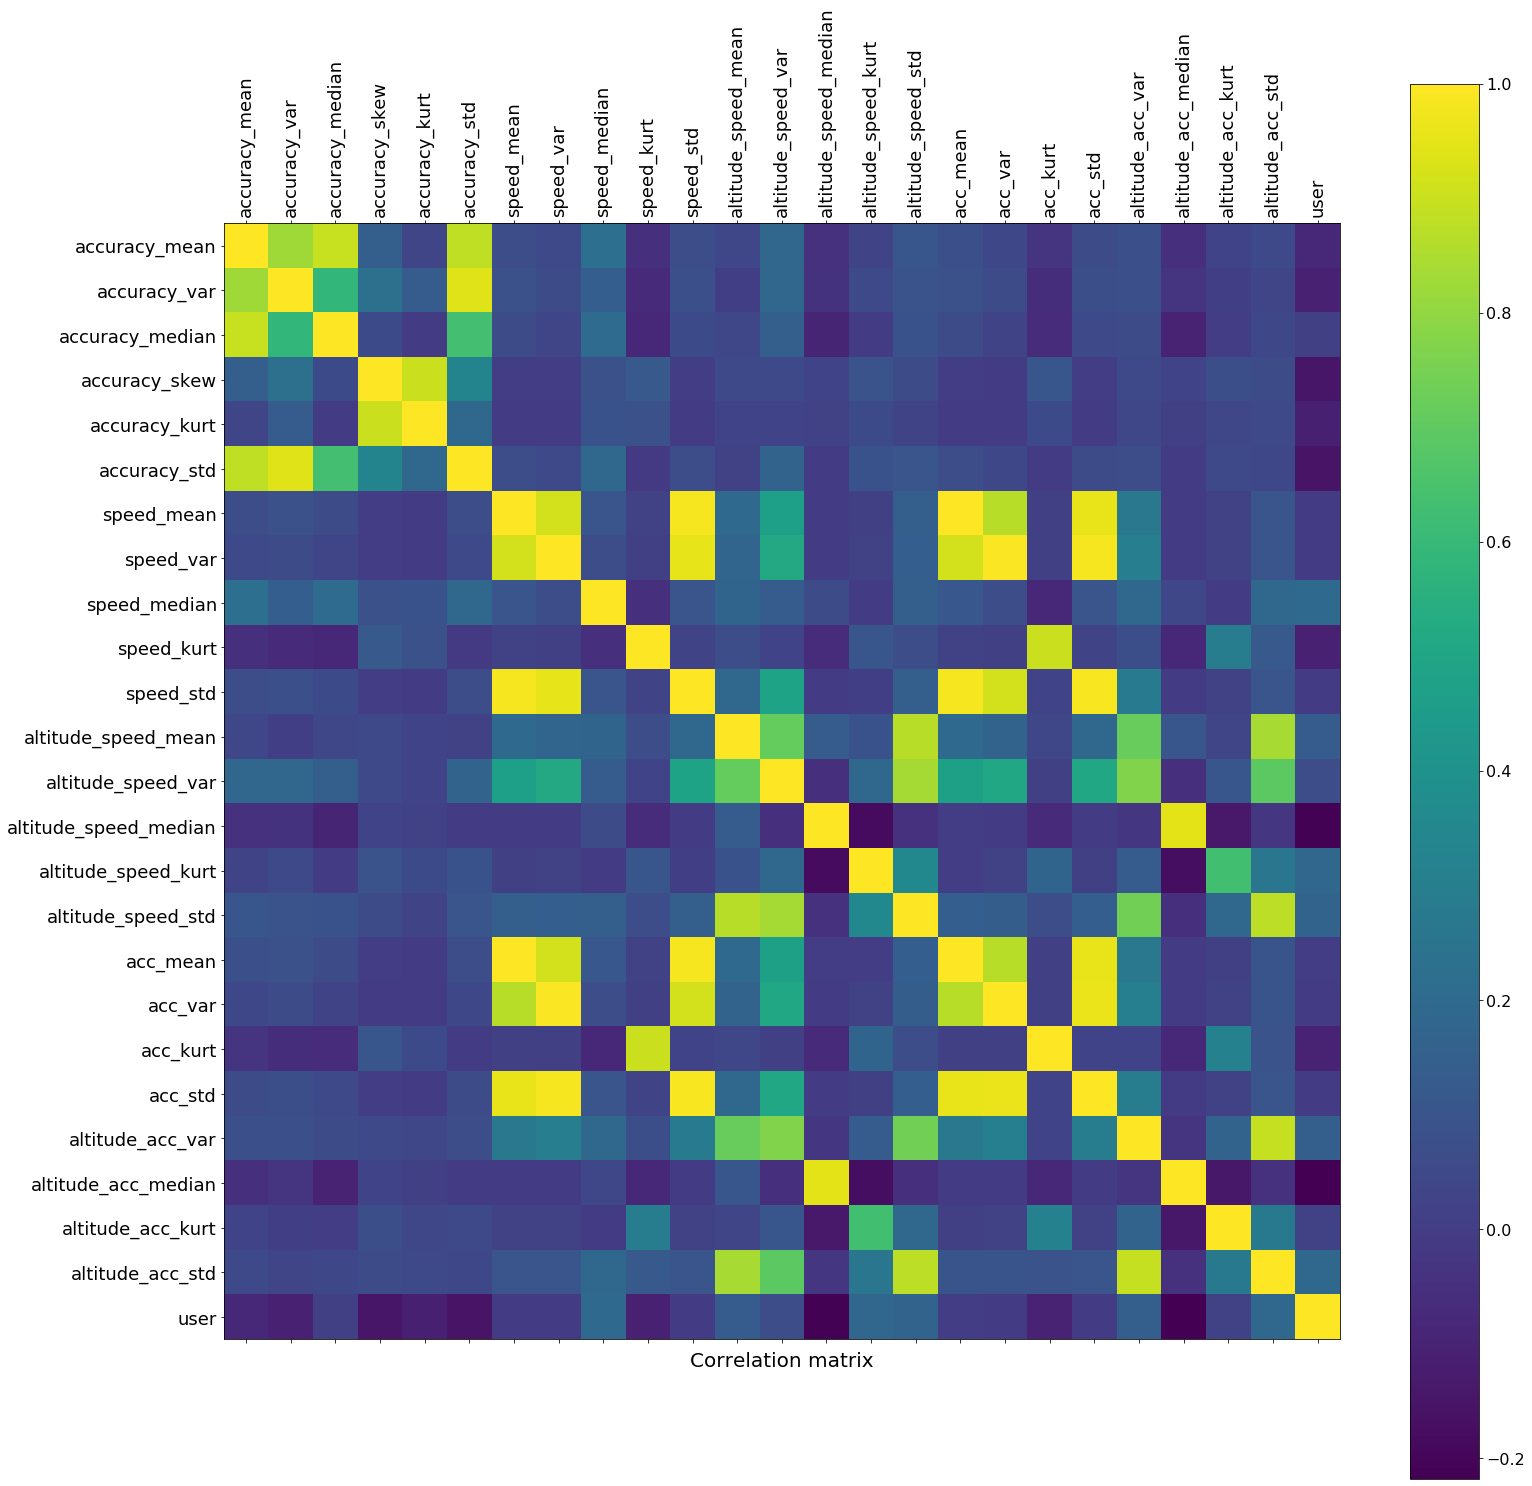

In [11]:
fig = plt.figure(figsize=(25, 25))
plt.matshow(df.corr(), fignum=fig.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=18, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=18)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.title("Correlation matrix", fontsize=20, y=-0.03)

In [12]:
corr_matrix = df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
corr_cols = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7) and column != "user"]
df = df.drop(corr_cols, axis=1)

In [13]:
# df.drop('user', axis=1).boxplot()

In [14]:
# sample = df.sample(10000)
# plt.figure(figsize=(16, 10))
# plt.scatter(x=sample['speed_mean'], y=sample['speed_var'], alpha=0.5, c=sample.user, cmap='magma')
# plt.colorbar()
# plt.show()

In [15]:
def resample(df):
    sampling_dfs = []
    need_count = 0

    for label, count in zip(df.user.value_counts().index, df.user.value_counts().values):
        if need_count == 0:
            need_count = count
            df_ = df[df.user == label]
            sampling_dfs.append(df_)
        else:
            df_ = df[df.user == label]
            df_over = df_.sample(need_count, replace=True, random_state=42)
            sampling_dfs.append(df_over)

    new_df = pd.concat(sampling_dfs)
    new_df = new_df.reset_index()

    return pd.concat(sampling_dfs)

In [16]:
def extract_delayed_user(df, user_label):
    df_user = df[df["user"] == user_label]
    df = df[df["user"] != user_label]
    return df_user, df

def split_users_into_two_classes(df, valid_user_label):
    df.loc[df["user"] != valid_user_label, "user"] = 0
    df.loc[df["user"] == valid_user_label, "user"] = 1
    return df

In [17]:
def get_cv_split(X, y, group_labels, valid_user_label):
    predefined_split_array = np.zeros(group_labels.shape[0])
    i = 0
    test_array = [x for x in range(group_labels.shape[0])]
    for test, _ in LeaveOneGroupOut().split(X, y, group_labels):
        diff = np.setdiff1d(test_array, test)
        if np.all(group_labels[diff[0] : diff[-1]] == valid_user_label) is np.bool_(True):
            for sample in diff:
                predefined_split_array[sample] = -1
        else:
            for sample in diff:
                predefined_split_array[sample] = i
            i += 1
    return predefined_split_array

In [18]:
# for user in df.user.unique():
#     for valid_user in df.user.unique():
#         if user != valid_user:
#             print('---------------------------------------------------------------------------')
#             print('Valid user: ', valid_user, 'Extracted user: ', user)
#             print('---------------------------------------------------------------------------')
#             df1, df_ = extract_delayed_user(df.copy(), user)
#             df1['user'] = 0
#             df_ = split_users_into_two_classes(df_.copy(), valid_user)
#             df_ = resample(df_)

#             dataset = df_.to_numpy()
#             X = dataset[:, :-1]
#             y = dataset[:, -1]

#             X_test = df1.to_numpy()[:, :-1]
#             y_test = df1.to_numpy()[:, -1]

#             model.fit(X, y, verbose=False)

#             preds_class = model.predict(X_test)
#             print('Accuracy: ', accuracy_score(preds_class, y_test))

#             sum_ = 0
#             imp = [ (x, i) for x, i in zip(model.feature_importances_, range(len(model.feature_importances_)) )]
#             sorted_ = sorted(imp, key=lambda tup: tup[0])
#             for i in range(len(sorted_)):
#                 if sorted_[i][0] > 5:
#                     print(sorted_[i][1], ': ', df_.columns[sorted_[i][1]], ' - ', sorted_[i][0])

#             print('---------------------------------------------------------------------------')
#             print('---------------------------------------------------------------------------')

## OneClassSVM GridSearchCV

In [19]:
# for user in df.labels.unique():
#     print("Valid User: ", user)
#     print("--------------------------------------------------------------------------------")

#     df_ = resample(df.copy())
#     df_ = split_users_into_two_classes(df_, user)
#     df_ = resample(df_)

#     group_labels = df_.labels.to_numpy().copy()
#     df_ = df_.drop('labels', axis=1)

#     dataset = df_.to_numpy().copy()
#     X = dataset[:, :-1]
#     y = dataset[:, -1]

#     cv_split = PredefinedSplit(test_fold=get_cv_split(X, y, group_labels, user))

#     clf = CatBoostClassifier()
#     params = {'iterations': [100, 500],
#               'depth': [6, 10],
#               'loss_function': ['Logloss', 'CrossEntropy'],
#               'l2_leaf_reg': [1, 10, 100],
#               'leaf_estimation_iterations': [5, 10],
#               'logging_level':['Silent'],
#               'random_seed': [42],
#               'task_type': ['GPU']
#              }

#     scorer = make_scorer(accuracy_score)
#     clf_grid = GridSearchCV(estimator=clf, param_grid=params, scoring=scorer, cv=cv_split)

#     clf_grid.fit(X, y)

#     best_params = clf_grid.best_params_
#     print('Best params: ', best_params)

#     print("--------------------------------------------------------------------------------")

## OneClassSVM CV & OneClassSVM Final Validation

In [ ]:
kernel = 'sigmoid'
degree = 3
gamma = 'scale'

df["labels"] = df["user"]

VALIDATION_ONE_SVM_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")

    df_ = df.copy()

    df_ = split_users_into_two_classes(df_.copy(), user)
    
    test_df = df_[df_.user == 0].copy()
    df_ = df_[df_.user == 1].copy()
    _df = df_.sample(int(0.25 * df_.shape[0])).copy()
    df_ = df_.drop(_df.index, axis=0)
    test_df = pd.concat([test_df, _df])
    df_ = df_.drop("labels", axis=1)

    dataset = df_.to_numpy().copy()
    np.random.shuffle(dataset)

    X = dataset[:, :-1]

    model = OneClassSVM(kernel=kernel, degree=degree, gamma=gamma)
    model.fit(X)

    # Testing
            
    # CV only on unknown users
    
    new_df_parts = []
    others_in_test_count = [test_df[test_df.labels == x].shape[0] \
                            for x in test_df.labels.unique() if x != user]
    
    min_test_count = min(others_in_test_count)
                    
    for x in test_df.labels.unique():
        if x != user:
            new_df_parts.append(test_df[test_df.labels == x].sample(min_test_count).copy())
                    
    test_df_unk = pd.concat(new_df_parts)
    test_df_unk.loc[:, "user"] = -1
    
    print("True: ", test_df_unk[test_df_unk['user'] == 1].shape)
    print("Shape: ", test_df_unk.shape)
    for x in test_df_unk.labels.unique():
        print("Count ", x, ": ", test_df_unk[test_df_unk.labels == x].shape)
    
    test_df_unk = test_df_unk.drop("labels", axis=1)

    test_dataset = test_df_unk.to_numpy().copy()
    X_test = test_dataset[:, :-1].copy()
    y_test = test_dataset[:, -1].copy()

    VALIDATION_ONE_SVM_BIG_DICT[str(user)] = {}
    VALIDATION_ONE_SVM_BIG_DICT[str(user)]['unknowns'] = {}
    VALIDATION_ONE_SVM_BIG_DICT[str(user)]['unknowns']["y_test"] = y_test.copy()
    VALIDATION_ONE_SVM_BIG_DICT[str(user)]['unknowns']["y_predict"] = model.predict(X_test).copy()

    print("Valid user = ", user, ", Unknowns", "accuracy = ",
            accuracy_score(VALIDATION_ONE_SVM_BIG_DICT[str(user)]['unknowns']["y_test"], 
                           VALIDATION_ONE_SVM_BIG_DICT[str(user)]['unknowns']["y_predict"])
         )
            
    # Valid and invalid

    valid_user_in_test_count = test_df[test_df.labels == user].shape[0]
    others_in_test_count = [test_df[test_df.labels == x].shape[0] \
                            for x in test_df.labels.unique() if x != user]

    min_others_test_count = min(others_in_test_count)

    is_important_min = True
    if min_others_test_count <= valid_user_in_test_count:
        is_important_min = False

    new_df_parts = []
    if is_important_min is True:
        part_size = valid_user_in_test_count
        other_sample_size = (2 * part_size) // len(others_in_test_count) + 1

    else:
        part_size_can_be = min_others_test_count * len(others_in_test_count) // 2
                        
        if part_size_can_be > valid_user_in_test_count:
            part_size = valid_user_in_test_count
            other_sample_size = (part_size * 2) // len(others_in_test_count) + 1
        else:
            part_size = part_size_can_be
            other_sample_size = min_others_test_count
                    
    new_df_parts.append(test_df[test_df.labels == user].sample(part_size).copy())

    for x in test_df.labels.unique():
        if x != user:
            new_df_parts.append(test_df[test_df.labels == x].sample(other_sample_size).copy())
                    
    test_df = pd.concat(new_df_parts)

    test_df.loc[test_df.labels != user, "user"] = -1
    test_df.loc[test_df.labels == user, "user"] = 1
    
    print("True: ", test_df[test_df.user == 1].shape)
    print("Shape: ", test_df.shape)
    for x in test_df.labels.unique():
        print("Count ", x, ": ", test_df[test_df.labels == x].shape)

    test_df = test_df.drop("labels", axis=1)

    test_dataset = test_df.to_numpy().copy()
    X_test = test_dataset[:, :-1].copy()
    y_test = test_dataset[:, -1].copy()

    VALIDATION_ONE_SVM_BIG_DICT[str(user)] = {}
    VALIDATION_ONE_SVM_BIG_DICT[str(user)]["with_valid"] = {}
    VALIDATION_ONE_SVM_BIG_DICT[str(user)]["with_valid"]["y_test"] = y_test.copy()
    VALIDATION_ONE_SVM_BIG_DICT[str(user)]["with_valid"]["y_predict"] = model.predict(X_test).copy()

    print("Valid user = ", user, ", With valid, ", "accuracy = ",
            accuracy_score(VALIDATION_ONE_SVM_BIG_DICT[str(user)]["with_valid"]["y_test"], 
                           VALIDATION_ONE_SVM_BIG_DICT[str(user)]["with_valid"]["y_predict"])
         )

    print("--------------------------------------------------------------------------------")

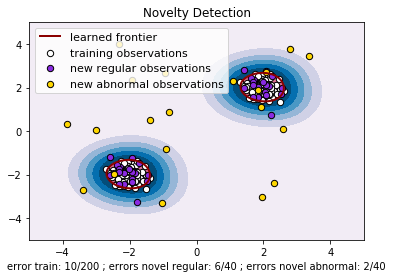

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()